This notebook is for evaluating the performance of the trained Deep Koopman Autoencoder.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import h5py
import numpy as np
from scipy.spatial.distance import cdist

from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics, plot_avg
from koopmag.data_utils import train_test_split
from koopmag.koopman_model import DeepKoopman, KoopmanAE

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [2]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "1000_150_40_16.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])
    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.e-07 2.e-07 3.e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [40 16  1]
seed: 0
t_per_step: 1.5e-11
t_steps: 150

Data in the database:
field: (1000, 3)
sequence: (1000, 150, 40, 16, 3)


In [3]:
_, test_dataset, train_indices, test_indices = train_test_split(
                                                DATA,
                                                Hs,
                                                dataset_type="full",
                                                test_size=0.2,
                                                seed=1,
                                                )       

In [4]:
batch_size = 12

testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f"max Hs: {np.max(Hs, axis=0)}")
print(f"min Hs: {np.min(Hs, axis=0)}")

max Hs: [49.49945 48.25204  0.     ]
min Hs: [-47.722034 -49.30808    0.      ]


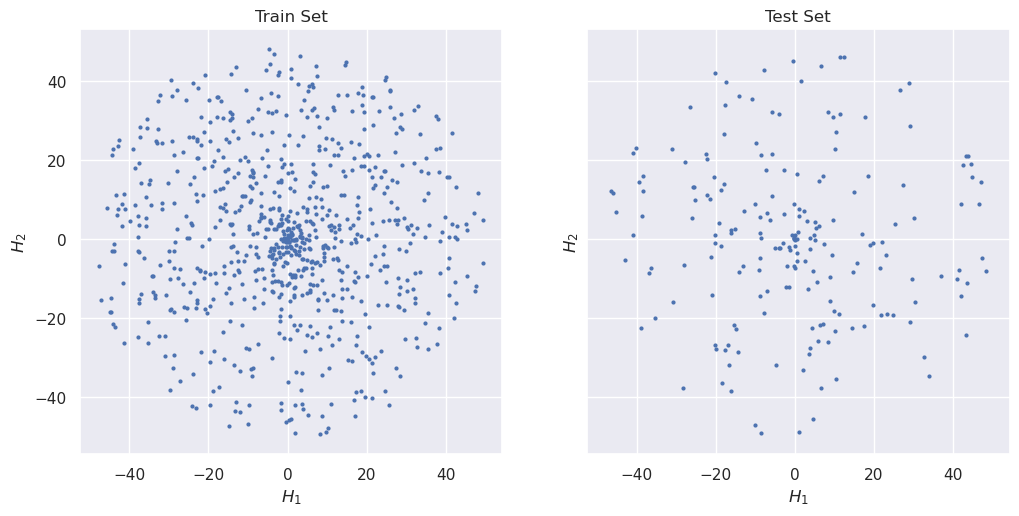

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

axs[0].plot(Hs[train_indices][:, 0], Hs[train_indices][:, 1], "o", markersize=2)
axs[0].set(title="Train Set", xlabel="$H_1$", ylabel="$H_2$", aspect="equal") 
axs[1].plot(Hs[test_indices][:, 0], Hs[test_indices][:, 1], "o", markersize=2)
axs[1].set(title="Test Set", xlabel="$H_1$", ylabel="$H_2$", aspect="equal")
plt.show()

## Check how similar the test set is to the training dataset

min dist: 0.03299704680133094, num: 0
max dist: 99.39877612503372
mean dist: 36.8938801541658
std dist: 19.039797607023313


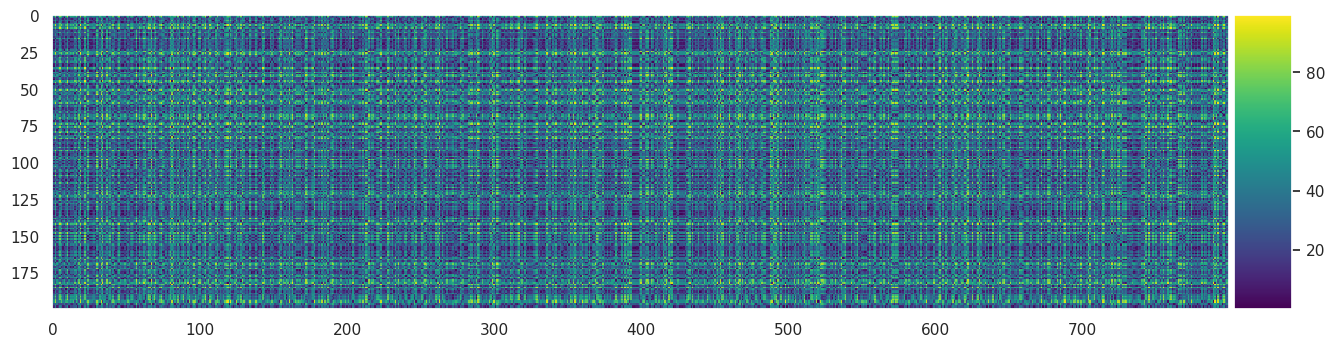

In [7]:
dist_mat = cdist(Hs[test_indices], Hs[train_indices], metric="euclidean")

print(f"min dist: {np.min(dist_mat)}, num: {np.sum(dist_mat == 0)}")
print(f"max dist: {np.max(dist_mat)}")
print(f"mean dist: {np.mean(dist_mat)}")
print(f"std dist: {np.std(dist_mat)}")

fig, ax = plt.subplots(figsize=(16, 12))
im = ax.imshow(
    dist_mat,
    cmap="viridis",
    interpolation="nearest",
    aspect="equal",
)
add_colorbar(im, fig, ax)
ax.grid(False)
plt.show()

## Koopman Autoencoder

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chns = [256, 128, 64]
latent_dim = 64
act_fn = nn.Tanh

LEARN_A = True

koopman = DeepKoopman(
    chns=chns,
    latent_dim=latent_dim,
    act_fn=act_fn,
    learn_A=LEARN_A,
    method="tikh",
    lam=5.
    ).to(device)

In [9]:
# load model parameters
koopman.load_state_dict(torch.load(datapath / "koopman_full_1000data_100epoch_32batch.pth", weights_only=True))
koopman = koopman.to(device)    

In [10]:
koopman.eval()

Ypreds = []
with torch.no_grad():
    for (xtest, utest) in testloader:
        xtest, utest = xtest.to(device), utest.to(device)
        yhat = koopman.predict(xtest[:, 0, :, :, :], utest)
        Ypreds.append(yhat.detach().cpu().numpy())

Ypreds = np.concatenate(Ypreds, axis=0)

In [11]:
Ypreds.shape

(200, 151, 40, 16, 3)

## Investigate where the model performs badly

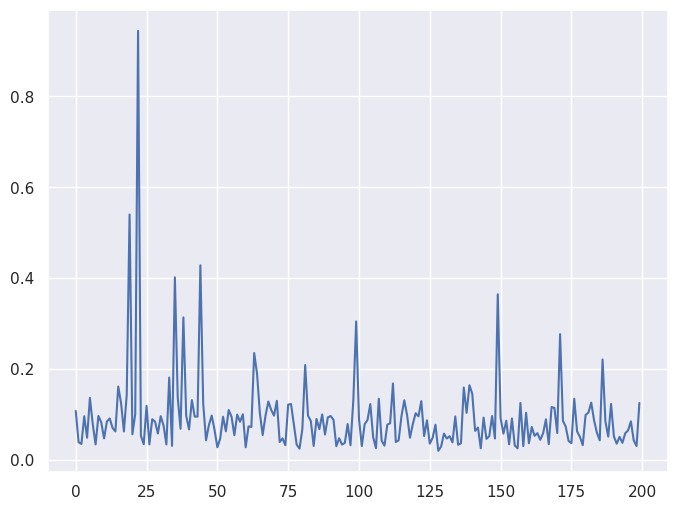

In [12]:
error2 = (DATA[test_indices] - Ypreds[:, :-1, :, :, :]) ** 2
mean_error2 = np.mean(error2, axis=(2, 3))          # mean squared error per pixel

total_mean_error2 = np.mean(mean_error2, axis=2)    # mean squared error across channels (mag componenents)      
total2_mean_error2 = np.mean(total_mean_error2, axis=1)    # mean squared error across time 

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.sqrt(total2_mean_error2))
plt.show()

In [13]:
check_idx = np.argwhere(np.sqrt(total2_mean_error2) > 0.2).flatten()
print(check_idx)

[ 19  22  35  38  44  63  81  99 149 171 186]


## Poor prediction examples:

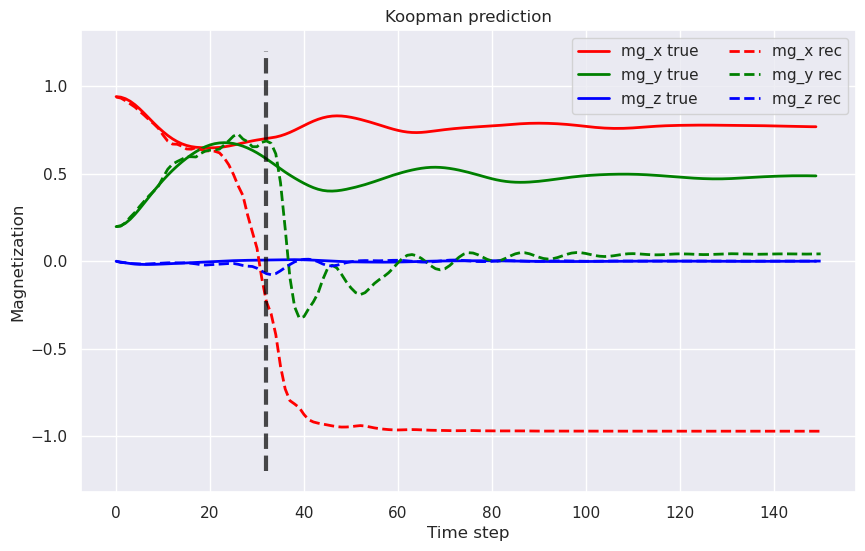

In [16]:
field_idx = check_idx[1]

fig, ax = plt.subplots(figsize=(10, 6))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Koopman prediction")
ax.vlines(x=[32], ymin=-1.2, ymax=1.2, color="black", linestyle="--", linewidth=3, alpha=0.7)
plt.show()

## Good prediction example:

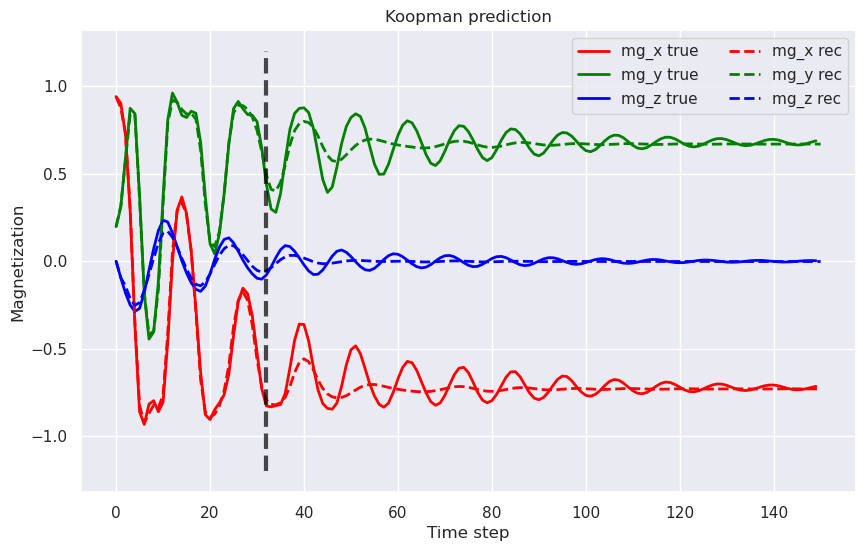

In [17]:
field_idx = 39

fig, ax = plt.subplots(figsize=(10, 6))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Koopman prediction")
ax.vlines(x=[32], ymin=-1.2, ymax=1.2, color="black", linestyle="--", linewidth=3, alpha=0.7)
plt.show()

In [77]:
koopman.eval()

Xrec = []
with torch.no_grad():
    for (xtest, _) in testloader:
        xtest = xtest.to(device)
        xhat = koopman.autoencoder(xtest)
        Xrec.append(xhat.detach().cpu().numpy())

del xtest
Xrec = np.concatenate(Xrec, axis=0)

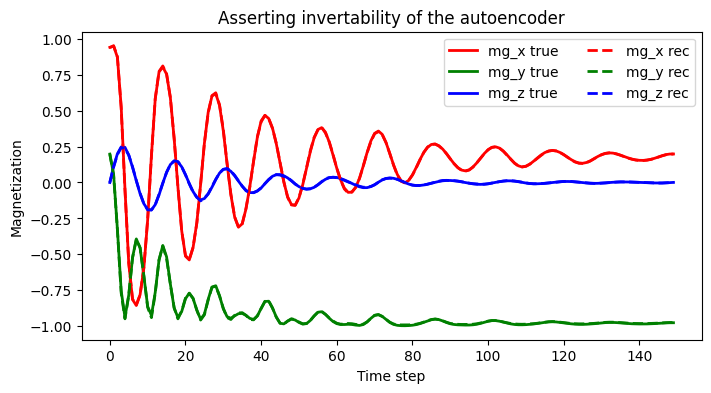

In [78]:
field_idx = 0

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Xrec[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Asserting invertability of the autoencoder")
plt.show()

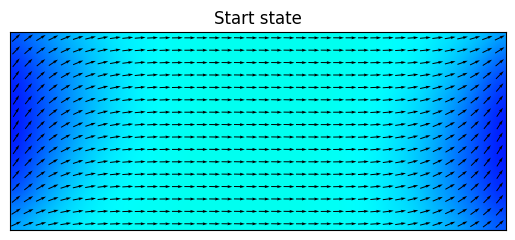

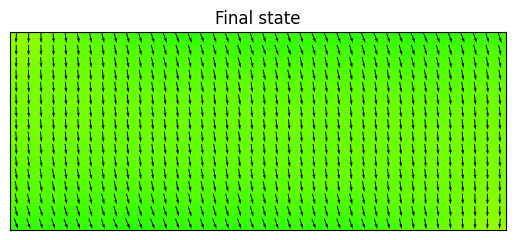

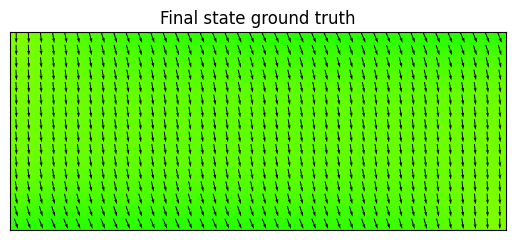

In [79]:
res = np.array([40, 16, 1])

plot_M_thin_film(Ypreds[field_idx][0], res, "Start state")
plot_M_thin_film(Ypreds[field_idx][-1], res, "Final state")
plot_M_thin_film(DATA[test_indices[field_idx]][-1], res, "Final state ground truth")